In [1]:
%%time
import uproot
input_file = uproot.open('/LLPData/Outputs/CalRatio_ntuples2016dataAnalysis_paperVersion/signal_HSS_LLP_mH125_mS25_lt9m_ntuples2016dataAnalysis_paperVersion.root')
base_awkward_array = input_file[input_file.keys()[0]].lazyarrays(namedecode='utf-8')
print(base_awkward_array)

{'eventNumber': <LazyArray 'eventNumber' at 7fdf848d89b0>, 'eventCount': <LazyArray 'eventCount' at 7fdf94355780>, 'runNumber': <LazyArray 'runNumber' at 7fdf848d89e8>, 'lumiBlock': <LazyArray 'lumiBlock' at 7fdf848d8a20>, 'backgroundFlags': <LazyArray 'backgroundFlags' at 7fdf848d8a58>, 'eventWeight': <LazyArray 'eventWeight' at 7fdf848d8a90>, 'pdfEventWeights': <LazyArray 'pdfEventWeights' at 7fdf848d8ac8>, 'pileupEventWeight': <LazyArray 'pileupEventWeight' at 7fdf848d8b00>, 'xSecEventWeight': <LazyArray 'xSecEventWeight' at 7fdf848d8b38>, 'actualIntPerCrossing': <LazyArray 'actualIntPerCrossing' at 7fdf848d8b70>, 'averageIntPerCrossing': <LazyArray 'averageIntPerCrossing' at 7fdf848d8ba8>, 'event_NCleanJets': <LazyArray 'event_NCleanJets' at 7fdf848d8c50>, 'event_NJets': <LazyArray 'event_NJets' at 7fdf848d8c18>, 'event_HT': <LazyArray 'event_HT' at 7fdf848d8c88>, 'event_MHToHT': <LazyArray 'event_MHToHT' at 7fdf848d8cc0>, 'event_HTMiss': <LazyArray 'event_HTMiss' at 7fdf848d8cf8>,

In [2]:
import sys
sys.path.append('..')
from clientlib.DataSets import ArrayDataSet
real_awkward_dataset = ArrayDataSet('/LLPData/Outputs/CalRatio_ntuples2016dataAnalysis_paperVersion/signal_HSS_LLP_mH125_mS25_lt9m_ntuples2016dataAnalysis_paperVersion.root')
real_awkward_array_stream = real_awkward_dataset.AsAwkwardArray()

In [3]:
real_awkward_query = real_awkward_array_stream.Select('lambda e: ((e.CalibJet_E, e.CalibJet_pT, e.CalibJet_eta, e.CalibJet_phi), (e.LLP_E, e.LLP_pT, e.LLP_eta, e.LLP_phi))')

In [4]:
%time output_array = real_awkward_query.value()

CPU times: user 38.1 ms, sys: 19.9 ms, total: 58.1 ms
Wall time: 7.59 s


In [5]:
from numpy import arcsinh, arctan2, hypot, isinf, cosh, cos, sin, sinh, sqrt
from math import pi

def get_eta_from_pT_and_pz(pT, pz):
    #if pT != 0:
        return arcsinh(pz / pT)
    #elif pz == 0:
    #    return 0
    #else:
    #    return float('infinity') * pz

class ThreeMomentum:
    def __init__(self, px, py, pz):
        self._px = px
        self._py = py
        self._pz = pz
        
    def __str__(self):
        return ('(' + str(self._px) + ', '
                    + str(self._py) + ', '
                    + str(self._pz) + ')')
    
    def px(self):
        return self._px
    
    def py(self):
        return self._py
    
    def pz(self):
        return self._pz
    
    def pT(self):
        return hypot(self._px, self._py)

    def eta(self):
        return get_eta_from_pT_and_pz(self.pT(), self._pz)
    
    def phi(self):
        return arctan2(self._py, self._px)
        
    def __add__(self, other):
        return ThreeMomentum(self._px + other._px, self._py + other._py, self._pz + other._pz)

def get_smallest_radian_value(angle):
    greater_than_pi = angle > pi
    while greater_than_pi.flatten().sum() if hasattr(greater_than_pi, "flatten") else greater_than_pi:
        greater_than_pi = greater_than_pi * -2 * pi
        angle = angle + greater_than_pi
        greater_than_pi = angle > pi
    less_than_negative_pi = angle < -pi
    while less_than_negative_pi.flatten().sum() if hasattr(less_than_negative_pi, "flatten") else less_than_negative_pi:
        less_than_negative_pi = less_than_negative_pi * 2 * pi
        angle = angle + less_than_negative_pi
        less_than_negative_pi = angle < -pi
    #while angle > pi:
    #    angle -= 2 * pi
    #while angle < -pi:
    #     angle += 2 * pi
    return angle

class FourMomentum:
    def __init__(self, E, pT, eta, phi):
        #if isinf(E) or E < pT or pT < 0:
        #    raise ValueError()
        #if E == 0:
        #    if pT != 0:
        #        raise ValueError()
        #    self._E = E
        #    self._pT = pT
        #    self._eta = float('nan')
        #    self._phi = float('nan')
        #elif pT == 0:
        #    if not isinf(eta):
        #        raise ValueError()
        #    self._E = E
        #    self._pT = pT
        #    self._eta = eta
        #    self._phi = float('nan')
        #else:
        #    if isinf(eta) or isinf(phi):
        #        raise ValueError()
        #    if (pT * cosh(eta)) / E > 1.001:
        #        raise ValueError()
            self._E = E
            self._pT = pT
            self._eta = eta
            self._phi = get_smallest_radian_value(phi)
            
    @classmethod
    def from_E_and_p3(cls, E, p3):
        return cls(E, p3.pT(), p3.eta(), p3.phi())
            
    def __str__(self):
        return (  'E = '   + str(self._E)   + ', '
                + 'pT = '  + str(self._pT)  + ', '
                + 'eta = ' + str(self._eta) + ', '
                + 'phi = ' + str(self._phi))
        
    def E(self):
        return self._E
    
    def pT(self):
        return self._pT
    
    def eta(self):
        return self._eta
    
    def phi(self):
        return self._phi
    
    def px(self):
        #if self._pT == 0:
        #    return 0
        #else:
            return self._pT * cos(self._phi)
    
    def py(self):
        #if self._pT == 0:
        #    return 0
        #else:
            return self._pT * sin(self._phi)
    
    def pz(self):
        #if isinf(self._eta):
        #    raise NotImplementedError('Unable to calculate pz if pT = 0')
        #else:
            return self._pT * sinh(self._eta)
        
    def eta(self):
        return self._eta
    
    def phi(self):
        return self._phi

    def p3(self):
        return ThreeMomentum(self.px(), self.py(), self.pz())
    
    def __add__(self, other):
        new_E = self._E + other._E
        new_p3 = self.p3() + other.p3()
        return self.from_E_and_p3(new_E, new_p3)
        
    def p3_squared(self):
        return self.px() ** 2 + self.py() ** 2 + self.pz() ** 2
        
    def p3_magnitude(self):
        return sqrt(self.p3_squared())
    
    def m(self):
        return sqrt(self._E ** 2 - self.p3_squared())
        
def deltaEta(v1, v2):
    return v2.eta() - v1.eta()

def deltaPhi(v1, v2):
    return get_smallest_radian_value(v2.phi() - v1.phi())

def deltaR(v1, v2):
    return hypot(deltaEta(v1, v2), deltaPhi(v1, v2))

In [6]:
jet_E = output_array[0][0]
jet_pT = output_array[0][1]
jet_eta = output_array[0][2]
jet_phi = output_array[0][3]
jet_p4 = FourMomentum(jet_E, jet_pT, jet_eta, jet_phi)
print(jet_p4)

E = [[209.45963567695793 50.8569008621466 38.23670360942477 ... 21.40224822199898 18.774834928534673 17.40520495450177] [112.48712674839861] [117.02456782852232 44.1294887862493 46.16908145502568 ... 22.096941297520168 782.6704830575734 317.13941773354424] ... [57.416778253996576 111.73028930427988 100.3586445209714 27.592001957999468 14.244165061146413] [162.73705793852082 142.10995895453976 585.0269147557975 24.83105007329888 74.48199795653571 273.0503216296591] [357.42336179498415 99.31800071982721 37.75215315751502 ... 61.866564091993425 48.329929732581455 16.277112520950926]], pT = [[85.585328125 30.156796875 27.329365234375 ... 19.114765625 17.340818359375 16.1868828125] [14.7517900390625] [113.56140625 43.05083984375 30.07937109375 ... 19.144345703125 17.670552734375 17.541751953125] ... [56.61165234375 41.1768125 22.341873046875 19.480361328125 13.2087236328125] [66.3442578125 36.03376171875 29.371841796875 24.554189453125 16.962095703125 9.3001416015625] [69.6013046875 31.3213

In [7]:
LLP_E = output_array[1][0]
LLP_pT = output_array[1][1]
LLP_eta = output_array[1][2]
LLP_phi = output_array[1][3]
LLP_p4 = FourMomentum(LLP_E, LLP_pT, LLP_eta, LLP_phi)
print(LLP_p4)

E = [[166898.46875 326920.8125] [356890.9375 529513.25] [103404.921875 48071.13671875] ... [39669.921875 151092.859375] [42666.09765625 162627.953125] [70134.3359375 88938.34375]], pT = [[65596.34050706915 27499.00248973422] [53715.604500843525 59307.0329832278] [97995.90286386282 30613.596643348257] ... [30642.91663307309 27082.546852699714] [33273.780559680905 41852.63399193613] [52071.77328625724 85218.6028044125]], eta = [[-1.5735909965496448 -3.1639988776541808] [2.5786739282626447 2.8781035894447142] [0.21816714748746974 0.8042243110563427] ... [-0.10153877242899736 2.3899102799825758] [-0.27870890534946097 2.02109331536214] [0.7042484844412646 0.056024844008052105]], phi = [[1.5547155588639499 -1.5469162668364922] [-2.6640841351235167 0.4444709134436521] [0.5668919842781024 -2.203021314329168] ... [-0.8517206835555559 2.767739799730511] [-2.2420660618770922 -1.7221149906968412] [1.447686064837975 -0.38342829173820453]]


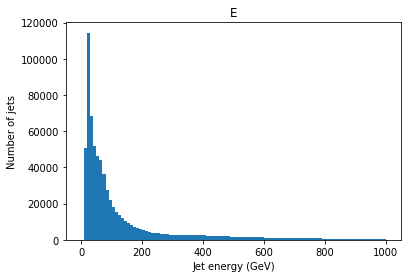

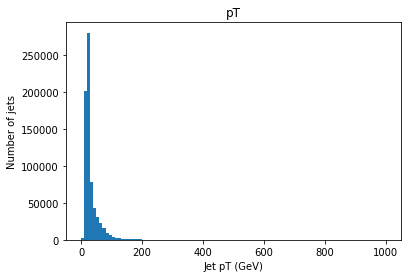

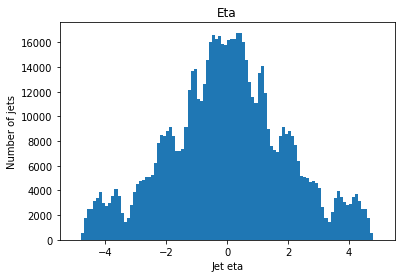

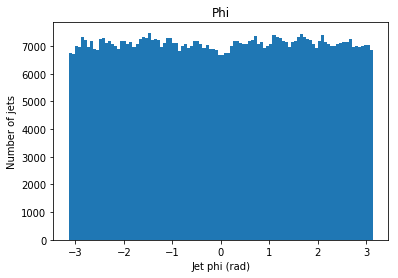

In [10]:
import matplotlib.pyplot as plt

plt.hist(jet_p4.E().flatten(), 100, (0,1000))
plt.title('E')
plt.xlabel('Jet energy (GeV)')
plt.ylabel('Number of jets')
plt.show()

plt.hist(jet_p4.pT().flatten(), 100, (0,1000))
plt.title('pT')
plt.xlabel('Jet pT (GeV)')
plt.ylabel('Number of jets')
plt.show()

plt.hist(jet_p4.eta().flatten(), 100, (-5,5))
plt.title('Eta')
plt.xlabel('Jet eta')
plt.ylabel('Number of jets')
plt.show()

plt.hist(jet_p4.phi().flatten(), 100, (-pi,pi))
plt.title('Phi')
plt.xlabel('Jet phi (rad)')
plt.ylabel('Number of jets')
plt.show()

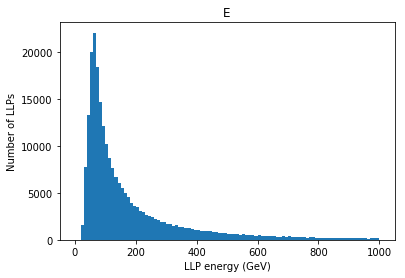

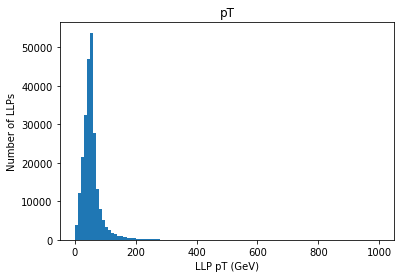

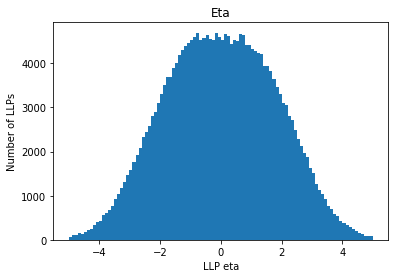

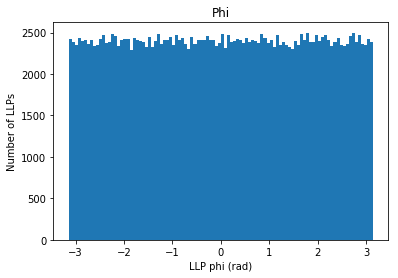

In [11]:
plt.hist(LLP_p4.E().flatten() / 1000, 100, (0,1000))
plt.title('E')
plt.xlabel('LLP energy (GeV)')
plt.ylabel('Number of LLPs')
plt.show()

plt.hist(LLP_p4.pT().flatten() / 1000, 100, (0,1000))
plt.title('pT')
plt.xlabel('LLP pT (GeV)')
plt.ylabel('Number of LLPs')
plt.show()

plt.hist(LLP_p4.eta().flatten(), 100, (-5,5))
plt.title('Eta')
plt.xlabel('LLP eta')
plt.ylabel('Number of LLPs')
plt.show()

plt.hist(LLP_p4.phi().flatten(), 100, (-pi,pi))
plt.title('Phi')
plt.xlabel('LLP phi (rad)')
plt.ylabel('Number of LLPs')
plt.show()